# **Lab 6**
# **Author: Sai Tallapragada**
# **Date: 2/28/2020**

# **Overview**

In this lab, we are trying to see if we can predict who to give Carvan Insurance to and who to avoid based upon various factors where we do not want to do business with high risk individuals. Ultimately, we are trying to see if we can predict who to offer the carvan insurance policy by trying to identify what are the mportant features of people who bought carvan insurance policy in the past. We will be using Logistic regression, Logistic regression with stepwise selection based on p-values, Random Forest based on Principal component analysis feature selection, and Random Forest based on feature importance feature selection to compare the results and trying to understnad what are the most important features that we should fit our model upon.

I used sources of code from Excercise 6 and I have also used the following sources to help finish this lab:[Source 1](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8) and [Source 2](https://towardsdatascience.com/machine-learning-step-by-step-6fbde95c455a).


In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# feature selection using LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# forward/backward feature selection based on p-value
import statsmodels.api as sm

# feature selection based on low variance
from sklearn.feature_selection import VarianceThreshold

import os  

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
%matplotlib inline
# forward/backward feature selection based on p-value
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# **Data**

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/INET 4061/caravan-insurance-challenge.csv") # Importing the data from a local file located in a local directory
aa = df.drop(['ORIGIN'], axis=1)
yy = aa['CARAVAN']
XX = aa.drop(['CARAVAN'], axis=1)
# We are creating Training and Testing datasets below.
testing=df[df['ORIGIN']=="test"]
training=df[df['ORIGIN']=="train"]
testing= testing.drop(['ORIGIN'], axis=1)
training= training.drop(['ORIGIN'], axis=1)
X_train=training.drop(['CARAVAN'], axis=1)
y_train = training['CARAVAN']
X_test=testing.drop(['CARAVAN'], axis=1)
y_test = testing['CARAVAN']


We are importing the data from a local file. We are also splitting the training and the testing dataset based upon the already given 59% training set to 41% testing set split from the ORGIN column.

# **Exploratory Data Analysis**

In [ ]:

#yy is the CARVAN column in the dataset.
print(yy[0:5]) # Displaying the first 5 values in the CARVAN dataset
yy_num=aa[aa["CARAVAN"]==0] #  We are storing all the vvalues of CARAVAN which equal 0 in yy_num
print("Orginal Dataset Shape:")
print(aa.shape) # aa number of rows indicate the total number of rows for the entire CARVAN column as well as the dataset.
print("The number of rows indicate the number of 0 values for CARAVAN in the orginal dataset:")
print(yy_num.shape) # yy_num number of rows indicate number of 0s in CARVAN column
XX.head()

0    0
1    0
2    0
3    0
4    0
Name: CARAVAN, dtype: int64
Orginal Dataset Shape:
(9822, 86)
The number of rows indicate the number of 0 values for CARAVAN in the orginal dataset:
(9236, 86)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


As we can see from above, the first 5 values from the CARAVAN column seem to be 0s. Further more, according to the shap of the variable aa and shape of the variable yy_num, there seems to be 9236 number of 0s in the CARAVAN column with only 586 number of 1s in the CARAVAN column. This is a very unbalnces distribution of data we are dealing with.


In [ ]:
df.isnull().values.any() # Checking for any null/missing values in our dataset

False

Since the following snippet of code above returned False, we can understand that there are no missing nor null values in our imported dataset.

In [ ]:
df.describe() # since they are as the same scale, no need for standardizaiton before feature selection.

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
count,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,...,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.00000,9822.000000,9822.000000,9822.000000
mean,24.253207,1.108735,2.677561,2.996437,5.779067,0.700672,4.637650,1.050092,3.262981,6.188964,0.873142,2.286602,1.887294,3.237324,4.302891,1.484525,3.307269,4.592038,1.898799,0.403278,0.545714,2.877113,2.226532,2.291183,1.650682,1.595093,2.204744,3.742211,1.068214,4.187742,4.819487,6.022501,1.335980,1.956730,6.254327,2.750662,2.577072,3.505498,2.739462,0.808491,...,2.956424,0.054877,0.170841,0.008858,0.019344,0.093565,0.011505,0.215027,0.202301,0.011505,0.018733,0.023315,1.849420,0.001629,0.015272,0.025351,0.016697,0.045408,0.400020,0.014050,0.021279,0.557218,0.011098,0.040216,0.002240,0.011403,0.034413,0.005192,0.071065,0.079821,0.004582,0.007941,0.004276,0.574018,0.000916,0.005091,0.03146,0.008450,0.013846,0.059662
std,12.918058,0.412101,0.780701,0.804660,2.874148,1.015107,1.721212,1.011156,1.606287,1.896070,0.961955,1.710674,1.779238,1.609139,1.984152,1.645968,1.723377,2.279839,1.814406,0.786792,1.106349,1.846703,1.748025,1.684008,1.742410,1.321487,1.534163,1.944900,1.298229,3.093127,3.093541,1.543980,1.213627,1.596842,2.000374,2.002960,2.073125,1.871365,1.950625,1.173771,...,2.921736,0.566108,0.888518,0.237556,0.200885,0.604350,0.215408,0.810899,0.910574,0.188699,0.213712,0.375350,1.881271,0.057058,0.244210,0.157198,0.211487,0.396983,0.492001,0.126058,0.144319,0.608575,0.129928,0.223622,0.068402,0.116251,0.249706,0.109954,0.267432,0.384431,0.067535,0.088764,0.071224,0.561255,0.030258,0.077996,0.20907,0.092647,0.117728,0.236872
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,0.000000,1.000000,0.000000,2.000000,3.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1

Further more, we can see that the mean of CARAVAN column is very low as it is 0.059662 and the number of rows we have in total are 9822. This means that only about 6 percent of the CARVAN column data has 1s and the 94 percent of the CARVAN column data is 0s.As discussed before, this indicates that CARVAN has a lot of 0s in its columns in comparision to values of 1s. This further helps us understand that we are dealing with a very unbalanced dataset. Even more, based of the table displayed above, we can also see that the column MOSTYPE seems to have a much larger range of values for its domain than the other features. This feature may be more influential than the rest for this reason in some cases.

# **Models**

### Stepwise Feature Selection Based on P values

I am doing Stepwise Feature Selection here and the data I get from thsi will be later used in the models section.

In [ ]:
y = aa['CARAVAN']
X = aa.drop(['CARAVAN'], axis=1)


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
#            best_feature = new_pval.argmin()
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  PPERSAUT                       with p-value 2.14684e-42
Add  MKOOPKLA                       with p-value 1.36739e-21
Add  PWAPART                        with p-value 3.66711e-15
Add  APLEZIER                       with p-value 8.20766e-15
Add  MOPLHOOG                       with p-value 4.25236e-06
Add  PBRAND                         with p-value 3.92829e-06
Add  MBERBOER                       with p-value 8.31838e-06
Add  MRELGE                         with p-value 1.41977e-05
Add  PWALAND                        with p-value 0.000361295
Add  ABRAND                         with p-value 0.000937601
Add  AZEILPL                        with p-value 0.00153041
Add  MINK123M                       with p-value 0.00152554
Add  PBYSTAND                       with p-value 0.00243579
Add  PGEZONG                        with p-value 0.00485648
Add  AGEZONG                        with p-value 0.00450709
Add  MHHUUR                         with p-value 0.00630075
resulting features:
['PPERSAUT

The results array which we printed above contains all the featured that are signinficant to use for the logistic regression later. In the following ocde cell below, we will be creatin training data based on these 16 features selected in the results array to use in our Logistic Regression in the models section.

In [ ]:
# Creating a new Dataset called X1 and X1_test which only have features which are selected from the stepwise feature slection process done above.
X1=X_train 
X1_test=X_test
y1=y
count=0
for i in X.columns:
  if i not in result: # Removing Every Feature not in the result array
    X1=X1.drop([i], axis=1)
    X1_test=X1_test.drop([i], axis=1)

print(X1.head())
print(X1.shape)
print(X1_test.shape)
#X1 is the x dataset and Y is y dataset used later in the Logistic regression with stepwise feature selection.
#X1_std = StandardScaler().fit_transform(X1) #Standardized X1 data


   MRELGE  MOPLHOOG  MBERBOER  MHHUUR  ...  AGEZONG  ABRAND  AZEILPL  APLEZIER
0       7         1         1       1  ...        0       1        0         0
1       6         0         0       2  ...        0       1        0         0
2       3         0         0       7  ...        0       1        0         0
3       5         3         0       5  ...        0       1        0         0
4       7         5         4       4  ...        0       1        0         0

[5 rows x 16 columns]
(5822, 16)
(4000, 16)


Based of the Data above, we can see that only the features from the results array are in our new X1 dataset as we removed all the other features from the original dataset that were not selected.

### PCA

We are doing PCA here and we will used the transformed data later in the models section to train and test our Random Forest Classifier.

Covariance matrix 
[[ 1.00010182 -0.04033167 -0.0065945  ... -0.0255354  -0.01633792
  -0.04375385]
 [-0.04033167  1.00010182 -0.00431565 ... -0.01252764  0.0319394
  -0.005852  ]
 [-0.0065945  -0.00431565  1.00010182 ...  0.01848839  0.01092878
   0.03085877]
 ...
 [-0.0255354  -0.01252764  0.01848839 ...  1.00010182  0.00204416
   0.00712214]
 [-0.01633792  0.0319394   0.01092878 ...  0.00204416  1.00010182
   0.01727922]
 [-0.04375385 -0.005852    0.03085877 ...  0.00712214  0.01727922
   1.00010182]]
Everything ok!


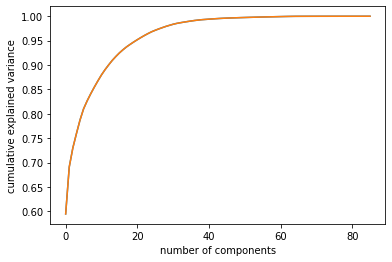

In [ ]:
all_vars = df.drop(['ORIGIN'], axis=1)
x_vars = all_vars.drop(['CARAVAN'], axis=1)
y = df['CARAVAN']

# principal component analysis 

# standardize the data 
X_std = StandardScaler().fit_transform(x_vars)
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

#Perform eigendecomposition on covariance matrix
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')
pca = PCA().fit(all_vars)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca = PCA(0.75).fit(X_train)
pca.n_components_

4

I am picking the .75 as a threshold for PCA.fit() because as we can see from the grah above, the number of components starts increasing much faster while the increase in the cumlative explained variance percentage decreases rapidly. I assumed that the tradeoff we get at .75 for only 4 newly created componenets are good to use later.

In [ ]:
X_train_scaled_pca = pca.transform(X_train)
X_test_scaled_pca = pca.transform(X_test)

In [ ]:
X_train_scaled_pca.shape

(5822, 4)

We are creating training and testing datasets above based upon PCA transformation to be later used for Random FOrest Classifier. in the models section.

### Logistic Regression

I used the following source to write code for logistic regression:[Source](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)

In [ ]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
import sklearn
# DOing logistic regression on orginal data.
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy of Logistic regression")
print(sklearn.metrics.accuracy_score(y_test, y_pred))
print("\n Precision of Logistic regression")
print(sklearn.metrics.precision_score(y_test, y_pred))
print("\n Recall of Logistic regression")
print(sklearn.metrics.recall_score(y_test, y_pred))
print("\n F1 score of Logistic regression")
print(sklearn.metrics.f1_score(y_test, y_pred))
print("\n \n")


Accuracy of Logistic regression
0.94075

 Precision of Logistic regression
0.6

 Recall of Logistic regression
0.012605042016806723

 F1 score of Logistic regression
0.02469135802469136

 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The normal logistic regression has a acuracy of 0.94075 with a Precision of 0.6, recall of 0.01261, and a fscore of 0.02469. This logistic regression classifier was trained on data with 85 features.

### Logistic regression with stepwise selection based on p-values

In [ ]:
logreg1 = LogisticRegression()
logreg1.fit(X1, y_train)
y_pred1 = logreg1.predict(X1_test)
print("Accuracy of Logistic regression with Stepwise selection")
print(sklearn.metrics.accuracy_score(y_test, y_pred1))
print("\n Precision of Logistic regression with Stepwise selection")
print(sklearn.metrics.precision_score(y_test, y_pred1))
print("\n Recall of Logistic regression with Stepwise selection")
print(sklearn.metrics.recall_score(y_test, y_pred1))
print("\n F1 score of Logistic regression with Stepwise selection")
print(sklearn.metrics.f1_score(y_test, y_pred1))
print("\n \n")


Accuracy of Logistic regression with Stepwise selection
0.9405

 Precision of Logistic regression with Stepwise selection
0.5

 Recall of Logistic regression with Stepwise selection
0.012605042016806723

 F1 score of Logistic regression with Stepwise selection
0.024590163934426233

 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The logistic regression with Stepwise selection based on p values has a accuracy of 0.9405 with a Precision of 0.5, recall of 0.01261, and a fscore of 0.02459. This classifier was trained on 16 features which were selected from the results array all the way back in Stepwise Feature Selection Based on P values.



### Random Forest With PCA

In [ ]:
from sklearn.ensemble import RandomForestClassifier
Y_train=np.array(y_train)
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
Y_predRFCPCA=rfc.predict(X_test_scaled_pca)


print("Accuracy of our Random Forest Classifier(PCA) on test dataset")
print(sklearn.metrics.accuracy_score(y_test,  Y_predRFCPCA))
print("\n Precision of our Random Forest Classifier(PCA) on test dataset")
print(sklearn.metrics.precision_score(y_test,  Y_predRFCPCA))
print("\n Recall of our Random Forest Classifier(PCA) on test dataset")
print(sklearn.metrics.recall_score(y_test, Y_predRFCPCA))
print("\n F1 score of our Random Forest Classifier(PCA) on test dataset")
print(sklearn.metrics.f1_score(y_test,  Y_predRFCPCA))
print("\n \n")


Accuracy of our Random Forest Classifier(PCA) on test dataset
0.93225

 Precision of our Random Forest Classifier(PCA) on test dataset
0.273972602739726

 Recall of our Random Forest Classifier(PCA) on test dataset
0.08403361344537816

 F1 score of our Random Forest Classifier(PCA) on test dataset
0.12861736334405144

 



The Random Forest CLassifier with PCA was trained and tested with data based upon only 4 PCA components which we got from doing PCA on our original data.

### Random Forest based on feature importance feature selection

Please Note that I used the following source to get the code for this section:[Source](https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/)

In [ ]:
# Create a random forest classifier
clf = RandomForestClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
feat_labels=X_train.columns
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)


sfm = SelectFromModel(clf, threshold=0.04)

# Train the selector
sfm.fit(X_train, y_train)

('MOSTYPE', 0.03927266647547531)
('MAANTHUI', 0.0055257581074749105)
('MGEMOMV', 0.009518393876906764)
('MGEMLEEF', 0.011859208543828048)
('MOSHOOFD', 0.02113995175491245)
('MGODRK', 0.01043044806167484)
('MGODPR', 0.018883361225282263)
('MGODOV', 0.012859226557693901)
('MGODGE', 0.018646911646539914)
('MRELGE', 0.014164798890611221)
('MRELSA', 0.009897751999971045)
('MRELOV', 0.01230210085755439)
('MFALLEEN', 0.014353964791900117)
('MFGEKIND', 0.01825389574274616)
('MFWEKIND', 0.017892726424798857)
('MOPLHOOG', 0.018141475701919655)
('MOPLMIDD', 0.01892604308007386)
('MOPLLAAG', 0.01727086293701907)
('MBERHOOG', 0.01585231609763914)
('MBERZELF', 0.00899051348680064)
('MBERBOER', 0.006558388772999742)
('MBERMIDD', 0.018724127720844534)
('MBERARBG', 0.017728160342541963)
('MBERARBO', 0.015392983458748455)
('MSKA', 0.014465874225388599)
('MSKB1', 0.0153529651172433)
('MSKB2', 0.015239092721105957)
('MSKC', 0.017073751984391466)
('MSKD', 0.011437892751548365)
('MHHUUR', 0.0160677972827092

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [ ]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

PPERSAUT
PBRAND
APERSAUT


The following three features are selected above as features that are significant :PPERSAUT
PBRAND,APERSAUT. This randomforest classifier will be trained and tested based upon these three features in the code cells below.

In [ ]:
X_important_train = sfm.transform(X_train) # Transforming our data based upon the results from feature selection.
X_important_test = sfm.transform(X_test)

In [ ]:
clf_important = RandomForestClassifier()

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:

y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (2 Features) Model
sklearn.metrics.accuracy_score(y_test, y_important_pred)
print("Accuracy of our Random Forest Classifier based on feature importance feature selection on test dataset")
print(sklearn.metrics.accuracy_score(y_test,  y_important_pred))

print("The precision, recall, and fscore with support are printed below")
sklearn.metrics.precision_recall_fscore_support(y_test, y_important_pred)


Accuracy of our Random Forest Classifier based on feature importance feature selection on test dataset
0.9405
The precision, recall, and fscore with support are printed below


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.9405, 0.    ]),
 array([1., 0.]),
 array([0.9693378, 0.       ]),
 array([3762,  238]))

As we can see from above, the precision, fscore, and recall are all 0 for the Random forest classiier with feature selection. This tells us that we have 0 true postives in our predictions and that is a very bad sign as it doesn't help us identify what features of people help influence on why they have carvan insurance policy.

# **Conclusion**


## Comparision of the performance measures for all Models

###  Logistic Regression
The normal logistic regression has a acuracy of 0.94075 with a Precision of 0.6, recall of 0.01261, and a fscore of 0.02469. This logistic regression classifier was trained on data with 85 features. We have a relatively good accuracy of 0.94 but we only had a precision of 0.6. This tells us that only 60% of true predictions(predicting that CARVAN column value is 1) were actually true.
However, we can see that recall is 0.0126 and this is significantly lower than the value we got for precision. This shows us that the number of false negatives in comparision true positives. This tells us that of those people who actually should be offered the Carvan insurance policy, our model was only able to correctly predict 1 % of those people who actually might be eligble to receive a carvan insurance policy.

Now lets take a look at Logistic regression with Stepwise Feature Selection

###  Logistic Regression With Stepwise Feature Selection based on p values
This logistic regression classifier was trained on 16 features instead of all 85 features(Not including CARAVAN column). The logistic regression with Stepwise selection based on p values has a accuracy of 0.9405, Precision of 0.5, recall of 0.01261, and a fscore of 0.02459. While the the logistic regression classiefier has slightly lower precision, accuracy, fscore than the normal logistic regression we did, the logistic regression with Stepwise Feature Selection was trained on only 16 features in comparision to the normal logistic regrssion which was trained on 85 different features. Since we got very comparable results, that may mean that our Stepwis Feature Slection based upon p values may have gotten very important features which influence the data greatly.
The 16 features we got from the Stepwise Feature Selection are 'PPERSAUT', 'MKOOPKLA', 'PWAPART', 'APLEZIER', 'MOPLHOOG', 'PBRAND', 'MBERBOER', 'MRELGE', 'PWALAND', 'ABRAND', 'AZEILPL', 'MINK123M', 'PBYSTAND', 'PGEZONG', 'AGEZONG', and 'MHHUUR'.

Furthermore, now lets compare our results we got from our logistic regression classifiers with the results we got from the random forest classifiers which will be discussed below.

###  RandomForest Classifier with PCA
The PCA we did gave us 4 PCA componenets which we transformed our training and testing data with. Then, we trained and tested the RandomFOrest Classifier with this PCA transformed data. For our Random Forest Classifier(PCA) on test dataset, the accuracy was 0.93225, Precision was 0.273972602739726, Recall 0.08403361344537816, and F1 score was 0.12861736334405144.

While we can see from our results that while our accuracy for this classifier was .93 adn as it was also similar to the accuracy of the logistic regression classifiers(0.94 on average), the precision for the Random Forest Classifier with PCA was only .27 and teh recall was 0.08. This tells us that the the number of true positives was very low in comparision to the number of true postives we got from the logistic regession classifiers because the logistic regression classifiers had a higher precision. However, the number of false negatives for this RandomForest Classifier with PCA might be slighly lower than the number of False negatives present in the results of the logistic regression classifiers because the recall for this RandomFOrest CLassifier was slightly higher(0.08>0.012). Thus, we can understand from this that the RandomForest classifier with PCA had a lower number of people falsely labeled as elegible to receive the Carvan insurance policy. This is good that the recall is higher because for an insurance company, it would cost them more to sign people who hav high risk factors than to potentially miss some people who could have been elgible customers. Overall, this RandomFOrest CLassifier with PCA did not perform well.

###  RandomForest Classifier based on feature importance feature selection
The RandomForest Classifier based on feature importance feature selection trained and tested on the following three important features selected from the Feature selection process which are PPERSAUT,PBRAND, and APERSAUT.

The precision, recall, and the fscore are 0s for this. This could be because my threshold was set to .04. However, what this shows me is that this classifier had no true positives at all. The accuracy is preety high as it was 0.9405. However, this is misleading because the classifier only predicted well on the 0s in the CARAVN column. This classifier did not do well but that could be because of my input parameters in the feature selection process.


###In Summary

Overall, the logistic egression models seemd to do better than the random forest classifiers based on the comparision of the results done above. The logistic regression with stepwise feature selection did very similary in comparision to the normal logistic regression. The following 16 significantfeatures we got from the Stepwise Feature Selection are 'PPERSAUT', 'MKOOPKLA', 'PWAPART', 'APLEZIER', 'MOPLHOOG', 'PBRAND', 'MBERBOER', 'MRELGE', 'PWALAND', 'ABRAND', 'AZEILPL', 'MINK123M', 'PBYSTAND', 'PGEZONG', 'AGEZONG', and 'MHHUUR'. Overall, I would say, our models had very low recalls so there is a good chance that they could falsely predict a very high number of people as eligible for CARVAN insurance policy.
